In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

In [21]:
datasets = {
    'Board Game Geek': 'knn/results/bg/',
    # 'Netflix Prize': 'knn/results/np/',
    # 'Movie Lens': 'knn/results/m/',
    # 'Yahoo Songs': 'knn/results/y/'
}

# Define k values to try
k_values = [5, 10, 25, 50, 100, 150, 250, 350, 500]
res_builder = pd.DataFrame(columns = ['dataset','fname','r2_value','k_value'])
res_items_per_user = dict()
for dataset_name, filename in datasets.items():
    for k in k_values:
        fname = filename+f"{k}_nn.feather"
        data = pd.read_feather(fname).dropna()
        slope,intercept,r_value,p_value,std_err = linregress(data['rating'],data['avg_rating'])
        res_builder.loc[len(res_builder.index)] = [dataset_name,fname,r_value**2,k]
        res_items_per_user[f"{fname}"] = data.groupby('user_id').agg({"item_id":"count"})

In [ ]:
def plot_violin_grid(data_dict, dataset_name, value_col='items_rated'):
    """
    Plots a grid of violin plots for one dataset (i.e., one dictionary of k -> DataFrame),
    using a logarithmic y-scale.
    
    Args:
        data_dict (dict): {k_value: DataFrame}
        dataset_name (str): Name of the dataset for the plot title
        value_col (str): Column in each df to plot (default: 'items_rated')
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style='whitegrid')
    
    ks = data_dict.keys()
    n = len(ks)
    
    cols = 3
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), sharey=True)
    axes = axes.flatten()

    for i, k in enumerate(ks):
        df_k = data_dict[k]
        sns.violinplot(y=df_k[value_col], ax=axes[i], inner='box', color='skyblue')
        axes[i].set_title(f'k = {k}')
        axes[i].set_ylabel("Items Rated")
        axes[i].set_xticks([])
        axes[i].set_yscale("log")

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"Violin Plots of Items Rated Per User\nDataset: {dataset_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


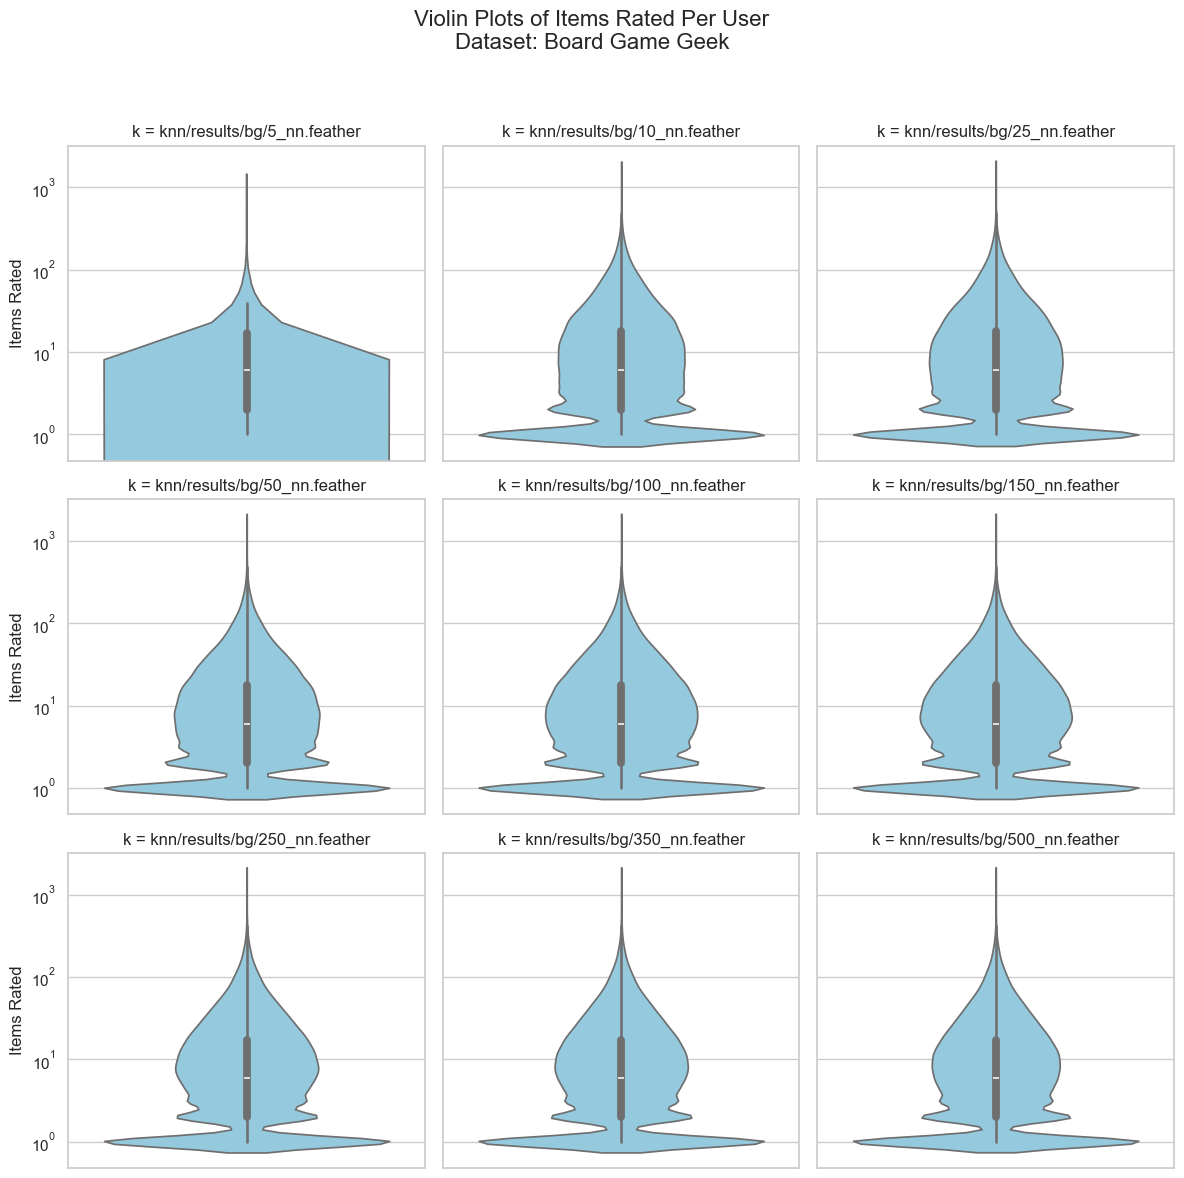

In [37]:
dataset = "bg"
filtered_dict = {key: value for key, value in res_items_per_user.items() if dataset in key}
plot_violin_grid(filtered_dict,"Board Game Geek","item_id")

In [ ]:
best_models = (
    res_builder.sort_values('r2_value', ascending=False)
      .groupby('dataset', as_index=False)
      .head(1)
)

In [ ]:
y_eval = pd.read_feather(best_models.loc[best_models['dataset']=='Yahoo Songs','fname'].item())
np_eval = pd.read_feather(best_models.loc[best_models['dataset']=='Netflix Prize','fname'].item())
m_eval = pd.read_feather(best_models.loc[best_models['dataset']=='Movie Lens','fname'].item())

In [ ]:

#sns boxplots
combined_df = pd.concat([np_eval, m_eval, y_eval], ignore_index=True)
sns.set(style='whitegrid')
g = sns.catplot(
    data=combined_df,
    x='rating',  
    y='ave_rating_pred',  
    col='dataset',  
    kind='box',
    height=4,
    aspect=0.8,
    sharey=True
)
g.set_axis_labels("Actual Rating", "Predicted Avg Rating")
g.set_titles("{col_name}")
g.tight_layout()
plt.show()
